Sources
---
- Implementation: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- GPU Speedup   : https://towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051

Import necessary libraries:
---

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Define a CNN architecture to process Cifar-10:
---
Accurate rendition: https://www.kaggle.com/juiyangchang/cnn-with-pytorch-0-995-accuracy

- Optimizer changed to Adam from SGD
- Works for both CPU and GPU implementations

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import math


class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,hidden_size, 5).cuda()
        self.conv2 = nn.Conv2d(hidden_size, 16, 5).cuda()
        self.pool  = nn.MaxPool2d(2, 2).cuda()
        self.fc1   = nn.Linear(16 * 5 * 5, 120).cuda()
        self.fc2   = nn.Linear(120, 84).cuda()
        self.fc3   = nn.Linear(84, 10).cuda()

    def forward(self, x):
        device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x = x.to(device)
        x = self.pool(F.relu(self.conv1(x))).cuda()
        x = self.pool(F.relu(self.conv2(x))).cuda()
        x = x.view(-1, 16 * 5 * 5).cuda()
        x = F.relu(self.fc1(x)).cuda()
        x = F.relu(self.fc2(x)).cuda()
        x = self.fc3(x).cuda()
        return x

To continue experiments, let's flush the GPU's CUDA allocated memory:
---

In [86]:
torch.cuda.empty_cache()

Parallel Data Loader for PyTorch
---
- Source: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

Now, let's change a bit about PyTorch's example Cifar-10 implementation.
---
GPU Utilization with the above implementation caps at around 4-7% on an EVGA GTX 980 SC.

Modified Preprocessing:
---
Previously, the PyTorch implementation handled sending images to the GPU in mini-batches of 4 images at a time. This stresses overhead communication between the CPU and GPU, forcing the CPU to ~60% while the GPU was barely breaching 6% utilization. First, instead of sending minibatches to the GPU, I'll modify PyTorch's example to actually send an entire batch at a time, and have the second batch preprocessed to eliminate GPU I/O waiting.

Changes: 
---
- Batch size increased to 512 images from 4
- Hidden size increased from 5 to 256
- Data augmented



In [110]:
torch.cuda.empty_cache()
device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The size of each batch.
BATCH_SIZE = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Training data split
trainset    = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Testing data split
testset     = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader  = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

classes     = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's take a look at the data:
---

Because of the normalization involved in the GPU transformations, a default, non-transformed version of the dataset is needed to visualize.

Files already downloaded and verified


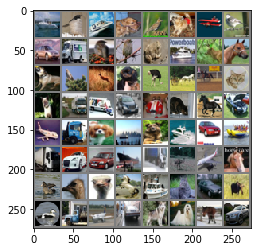

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Necessary to actually see the images
%matplotlib inline 

# Getting a clean dataset
view_transform   = transforms.Compose(
                   [transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
view_trainset    = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=view_transform)
view_trainload   = torch.utils.data.DataLoader(view_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(view_trainload)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
images, labels = dataiter.next()
    
del view_trainset, view_trainload, view_transform

During training, we'll utilize a function to see how well we're doing on the test set:
---

In [11]:
def test(epoch, net, criterion):
    device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    start = time.time()
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    losses = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            losses.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        stop = time.time()
        print('[Time: %4.3fs][epoch %3d] Loss: %.3f | Acc: %.3f%% (%d/%d)'%(stop - start, epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Return the accuracy
    return 100.*correct/total

Modified training:
---

In [12]:
import time
class Runtime_Info(object):
    def __init__(self, acc_progression, all_losses, runtime, pre_time, pro_time, com_time, rounds, accuracy, network):
        self.acc_progression  = acc_progression
        self.all_losses       = all_losses
        self.runtime          = runtime
        self.pre_time         = pre_time
        self.pro_time         = pro_time
        self.com_time         = com_time
        self.rounds           = rounds
        self.accuracy         = accuracy
        self.network          = network
        
    def __cmp__(self, other):
        if hasattr(other, 'accuracy'):
            return other.accuracy.__cmp__(self.accuracy)

def Run_Test(Network_Size, Batch_Size, Learning_Rate, Batch_Loops, minutes):
    # Prepare the dataset:
    torch.cuda.empty_cache()
    
    # Create the network and send it to the GPU
    device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net             = Net(Network_Size).cuda()
    net             = net.to(device)
    #print("Cuda available? " + str(next(net.parameters()).is_cuda))

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(net.parameters(), lr=Learning_Rate, momentum=0.9, weight_decay=5e-4)

    # Network parameters
    max_epochs         = 10000
    running_loss       = 0.0
    preprocessing_time = 0. 
    processing_time    = 0.
    i                  = 0
    prInterval         = 10
    all_losses         = []
    epoch_times        = []
    acc_progression    = []

    # Event timing
    start = 0
    stop  = 0

    # Epoch timing
    beginning = 0
    end       = 0

    # Timing data for analysis
    runtime   = 0
    pre_time  = 0
    pro_time  = 0
    com_time  = 0
    rounds    = 0

    # Full training loop
    runtime   = time.time()
    for epoch in range(max_epochs):
        # Training
        print("[Epoch %d duration: %3.3fs][Total duration: %3.3fs]\n"% (epoch, float(end - beginning), float(time.time() - runtime)))
        beginning = time.time()
    
        for local_batch, local_labels in trainloader:
            start = time.time()
            inputs, labels = local_batch.to(device), local_labels.to(device)
        
            stop  = time.time()
            preprocessing_time += stop - start
            start = time.time()
        
            # Force five walks over this batch before evicting from GPU
            optimizer.zero_grad()
            
            for i in range(Batch_Loops):
                outputs = net(inputs).cuda()
                loss    = criterion(outputs, labels).cuda()
                loss.backward()
                optimizer.step()
            
            del inputs, labels

            # print statistics
            running_loss += loss.item()
        
            # Record the loss for visualization of training
            all_losses.append(loss.item())
            i += 1
        
            stop = time.time()
            processing_time += stop - start
        
        end       = time.time()
        comm_time = (end- beginning) - processing_time - preprocessing_time
        print('[Time: %4.3fs][epoch %3d] loss: %.5f , compute time %.3f, comm. overhead %.3f, epoch tot. time %3.3f' %
                (stop - beginning, epoch + 1, running_loss / i, processing_time, comm_time, end - beginning) )
    
        # Create a tupe of (Epoch Time, Processing Time, Preprocessing Time, Communication time, Overall time)
        epoch_times.append((end - beginning, processing_time, preprocessing_time, comm_time, end - runtime))
    
        # Keep record of the total portion of runtime each section requires
        pro_time += processing_time
        com_time += comm_time
        pre_time += preprocessing_time
        rounds   += 1
        running_loss       = 0.0
        preprocessing_time = 0
        processing_time    = 0
        i                  = 0
            
        # Iterate over epochs until either 80% accuracy or 5 hours of training
        accuracy       = test(epoch, net, criterion)
    
        # Record accuracy for visualization of accuracy progression
        acc_progression.append(accuracy)
        if accuracy > 90 or float(time.time() - runtime) > (60 * minutes):
            break

    # Calculate the final runtime
    total_time = time.time() - runtime
    accuracy   = max(acc_progression)
    print("Final accuracy over %d Epochs: %3.3f, Elapsed time: %3.3f"%(rounds, accuracy, total_time))
    return Runtime_Info(acc_progression, all_losses, runtime, pre_time, pro_time, com_time, rounds, accuracy, net.state_dict())

Let's do a long session of training the model in 10 minute tests:
---

In [ ]:
Learning_Rates = [.001]
Network_Sizes  = [512, 1024]
Batch_Sizes    = [16, 32]
runtime        = 30

# Test various setups to find best learning scheme (135 mins, or 2 hrs 15 mins)
test_start = time.time()
Run_Data = []
Setups   = []
max_acc    = 0
best_setup = 0
for net_size in Network_Sizes:
    for batch_size in Batch_Sizes:
        for learning_rate in Learning_Rates:
            torch.cuda.empty_cache()
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

            # Training data split
            trainset    = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

            # Testing data split
            testset     = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
            testloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
            
            print("BEGINNING TEST: Net Size: %3d, Batch Size: %3d, Batch Loops %d"%(net_size, batch_size, 1))
            Run_Data.append(Run_Test(net_size, batch_size, learning_rate, 1, runtime))
            Setups.append((net_size, batch_size, 1))
            if(Run_Data[-1].accuracy > max_acc):
                max_acc    = Run_Data[-1].accuracy
                best_setup = Setups[-1]
                
            curr_time  = time.time() - test_start
            seconds    = curr_time
            minutes    = seconds / 60
            seconds    = seconds % 60
            hours      = minutes / 60
            minutes    = minutes % 60
            print("TOTAL TEST ELAPSED TIME: %d hours %d minutes %d seconds"%(hours, minutes, seconds))

BEGINNING TEST: Net Size: 512, Batch Size:  16, Batch Loops 1
[Epoch 0 duration: 0.000s][Total duration: 0.000s]

[Time: 28.303s][epoch   1] loss: 5712.19540 , compute time 25.285, comm. overhead 2.710, epoch tot. time 28.303
[Time: 3.892s][epoch   0] Loss: 1.542 | Acc: 42.780% (4278/10000)
[Epoch 1 duration: 28.303s][Total duration: 32.198s]

[Time: 29.071s][epoch   2] loss: 4858.17810 , compute time 26.030, comm. overhead 2.684, epoch tot. time 29.072
[Time: 3.928s][epoch   1] Loss: 1.418 | Acc: 47.720% (4772/10000)
[Epoch 2 duration: 29.072s][Total duration: 65.201s]

[Time: 28.932s][epoch   3] loss: 4484.41316 , compute time 25.939, comm. overhead 2.675, epoch tot. time 28.932
[Time: 3.902s][epoch   2] Loss: 1.375 | Acc: 48.430% (4843/10000)
[Epoch 3 duration: 28.932s][Total duration: 98.038s]

[Time: 29.076s][epoch   4] loss: 4268.25468 , compute time 26.109, comm. overhead 2.685, epoch tot. time 29.077
[Time: 3.901s][epoch   3] Loss: 1.225 | Acc: 55.380% (5538/10000)
[Epoch 4 dur

[Time: 3.898s][epoch  34] Loss: 0.863 | Acc: 69.590% (6959/10000)
[Epoch 35 duration: 29.083s][Total duration: 1157.978s]

[Time: 28.962s][epoch  36] loss: 2896.71726 , compute time 25.978, comm. overhead 2.700, epoch tot. time 28.963
[Time: 3.942s][epoch  35] Loss: 0.899 | Acc: 68.440% (6844/10000)
[Epoch 36 duration: 28.963s][Total duration: 1190.886s]

[Time: 28.982s][epoch  37] loss: 2888.18413 , compute time 25.960, comm. overhead 2.688, epoch tot. time 28.982
[Time: 3.913s][epoch  36] Loss: 0.913 | Acc: 68.250% (6825/10000)
[Epoch 37 duration: 28.982s][Total duration: 1223.785s]

[Time: 29.108s][epoch  38] loss: 2866.33825 , compute time 26.074, comm. overhead 2.705, epoch tot. time 29.109
[Time: 3.903s][epoch  37] Loss: 0.889 | Acc: 68.580% (6858/10000)
[Epoch 38 duration: 29.109s][Total duration: 1256.799s]

[Time: 29.262s][epoch  39] loss: 2860.77817 , compute time 26.194, comm. overhead 2.723, epoch tot. time 29.262
[Time: 3.925s][epoch  38] Loss: 0.870 | Acc: 69.340% (6934/1

[Time: 3.153s][epoch  13] Loss: 1.084 | Acc: 61.650% (6165/10000)
[Epoch 14 duration: 22.162s][Total duration: 355.778s]

[Time: 22.343s][epoch  15] loss: 1721.86906 , compute time 19.408, comm. overhead 2.718, epoch tot. time 22.343
[Time: 2.988s][epoch  14] Loss: 1.037 | Acc: 62.720% (6272/10000)
[Epoch 15 duration: 22.343s][Total duration: 381.112s]

[Time: 22.128s][epoch  16] loss: 1690.89054 , compute time 19.294, comm. overhead 2.640, epoch tot. time 22.128
[Time: 2.982s][epoch  15] Loss: 1.039 | Acc: 63.290% (6329/10000)
[Epoch 16 duration: 22.128s][Total duration: 406.225s]

[Time: 22.214s][epoch  17] loss: 1674.80702 , compute time 19.369, comm. overhead 2.635, epoch tot. time 22.214
[Time: 3.026s][epoch  16] Loss: 1.008 | Acc: 63.430% (6343/10000)
[Epoch 17 duration: 22.214s][Total duration: 431.468s]

[Time: 22.151s][epoch  18] loss: 1643.04839 , compute time 19.292, comm. overhead 2.678, epoch tot. time 22.151
[Time: 2.977s][epoch  17] Loss: 0.986 | Acc: 64.590% (6459/10000

[Time: 22.123s][epoch  49] loss: 1373.90513 , compute time 19.271, comm. overhead 2.657, epoch tot. time 22.123
[Time: 2.974s][epoch  48] Loss: 0.848 | Acc: 70.240% (7024/10000)
[Epoch 49 duration: 22.123s][Total duration: 1239.943s]

[Time: 22.103s][epoch  50] loss: 1372.80410 , compute time 19.275, comm. overhead 2.643, epoch tot. time 22.104
[Time: 2.989s][epoch  49] Loss: 0.855 | Acc: 70.210% (7021/10000)
[Epoch 50 duration: 22.104s][Total duration: 1265.039s]

[Time: 22.068s][epoch  51] loss: 1370.67573 , compute time 19.271, comm. overhead 2.619, epoch tot. time 22.068
[Time: 2.959s][epoch  50] Loss: 0.840 | Acc: 70.400% (7040/10000)
[Epoch 51 duration: 22.068s][Total duration: 1290.069s]

[Time: 22.101s][epoch  52] loss: 1361.27938 , compute time 19.276, comm. overhead 2.646, epoch tot. time 22.101
[Time: 2.976s][epoch  51] Loss: 0.828 | Acc: 70.260% (7026/10000)
[Epoch 52 duration: 22.101s][Total duration: 1315.150s]

[Time: 22.094s][epoch  53] loss: 1362.72526 , compute time 1

[Time: 48.484s][epoch  11] loss: 3728.51471 , compute time 45.391, comm. overhead 2.749, epoch tot. time 48.484
[Time: 6.250s][epoch  10] Loss: 1.112 | Acc: 60.270% (6027/10000)
[Epoch 11 duration: 48.484s][Total duration: 604.084s]

[Time: 48.529s][epoch  12] loss: 3662.43671 , compute time 45.428, comm. overhead 2.740, epoch tot. time 48.529
[Time: 6.248s][epoch  11] Loss: 1.119 | Acc: 59.560% (5956/10000)
[Epoch 12 duration: 48.529s][Total duration: 658.864s]

[Time: 48.499s][epoch  13] loss: 3637.50392 , compute time 45.396, comm. overhead 2.726, epoch tot. time 48.500
[Time: 6.259s][epoch  12] Loss: 1.114 | Acc: 60.330% (6033/10000)
[Epoch 13 duration: 48.500s][Total duration: 713.625s]

[Time: 48.578s][epoch  14] loss: 3582.60447 , compute time 45.474, comm. overhead 2.748, epoch tot. time 48.578
[Time: 6.220s][epoch  13] Loss: 1.109 | Acc: 59.920% (5992/10000)
[Epoch 14 duration: 48.578s][Total duration: 768.426s]

[Time: 48.514s][epoch  15] loss: 3556.44732 , compute time 45.41

Now that we've finished all of those runs, let's save the data into a pandas dataframe:
---

Successfully created the directory.
Successfully created the directory.


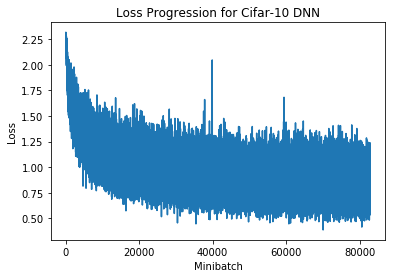

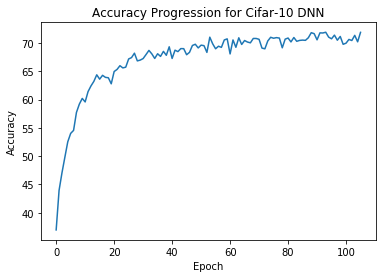

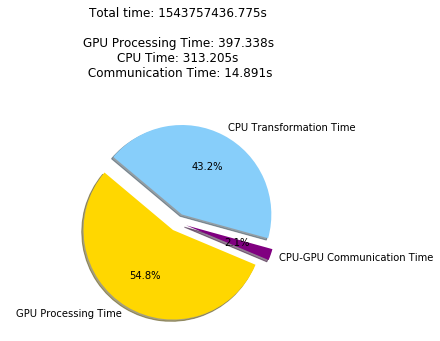

Successfully created the directory.


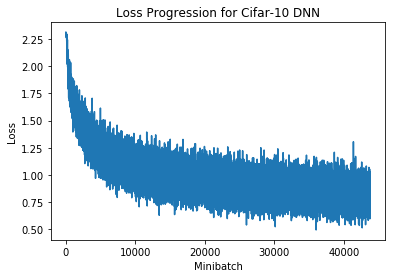

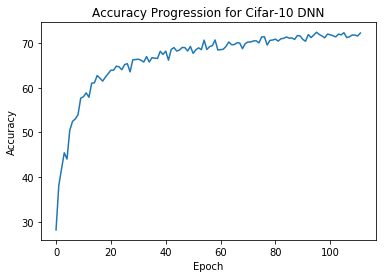

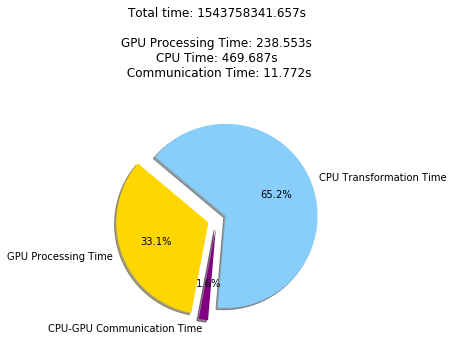

Successfully created the directory.


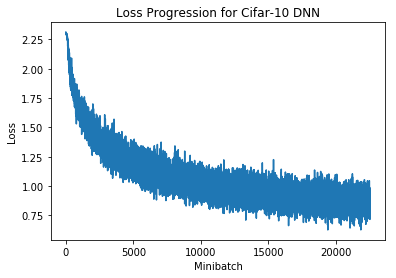

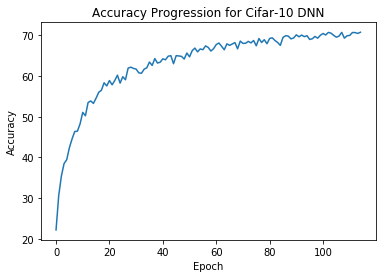

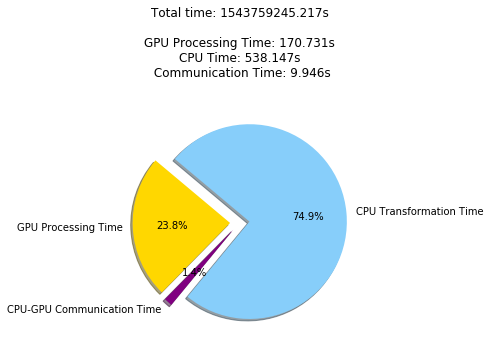

Successfully created the directory.


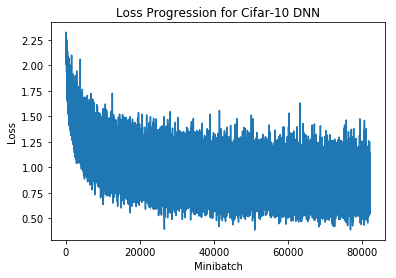

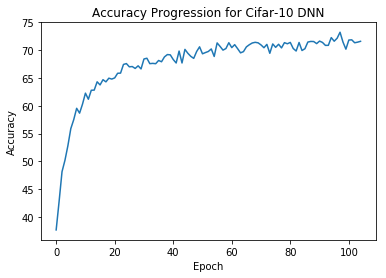

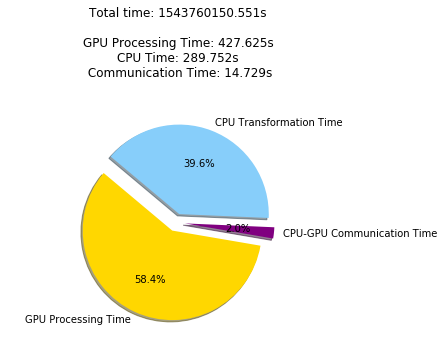

Successfully created the directory.


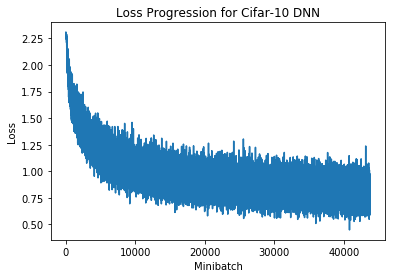

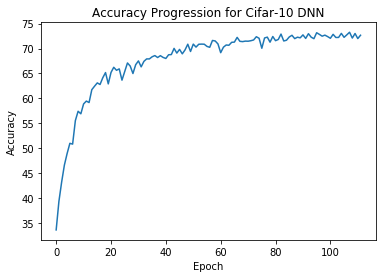

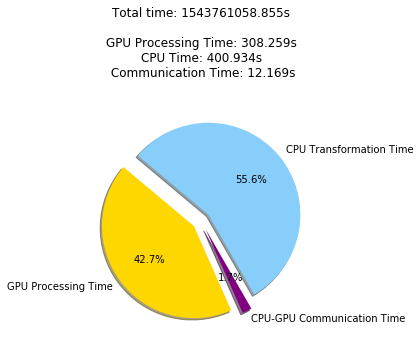

Successfully created the directory.


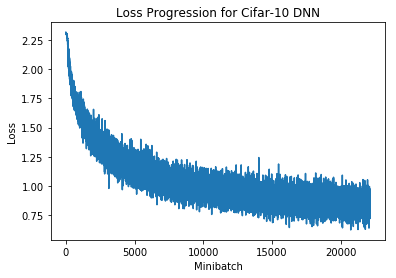

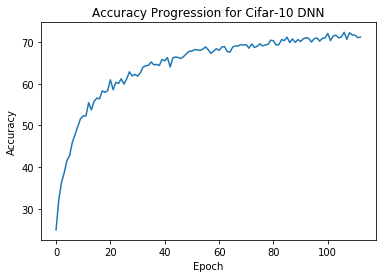

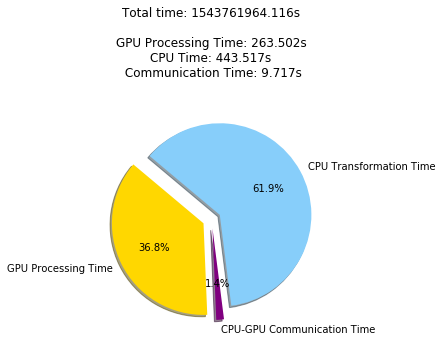

Successfully created the directory.


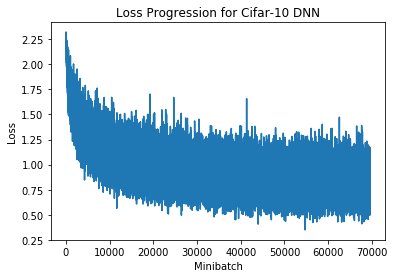

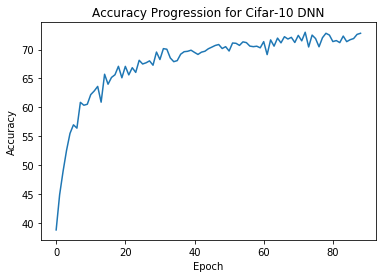

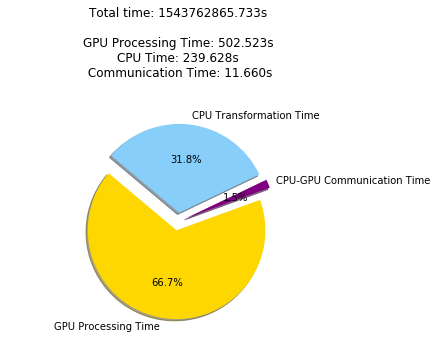

Successfully created the directory.


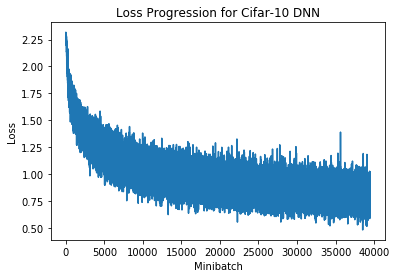

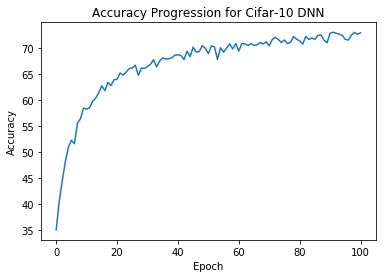

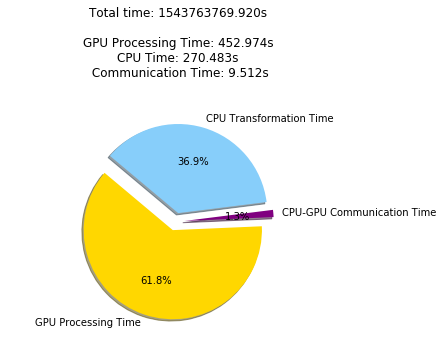

Successfully created the directory.


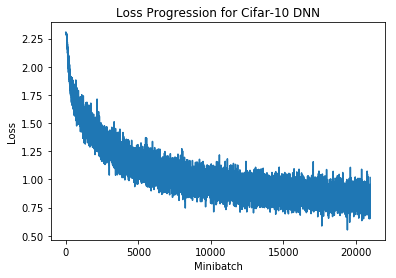

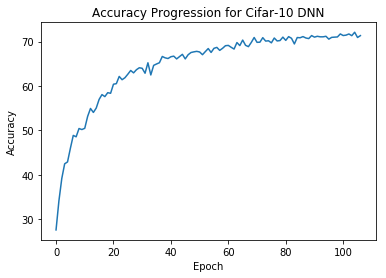

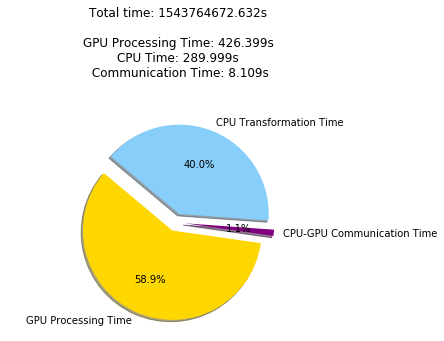

Successfully created the directory.


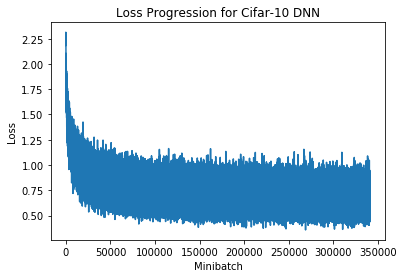

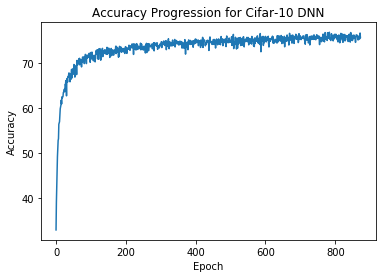

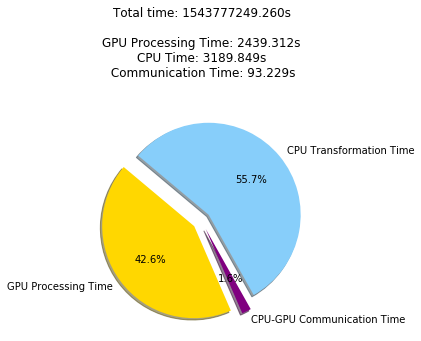

Successfully created the directory.


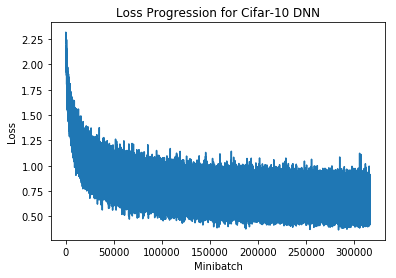

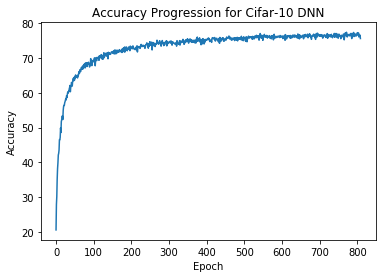

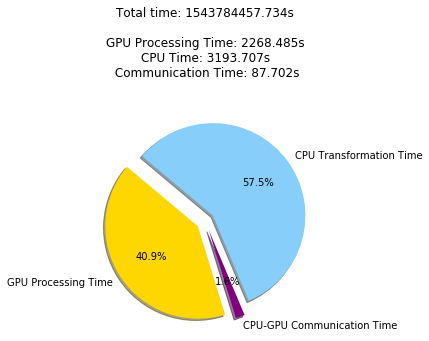

Successfully created the directory.


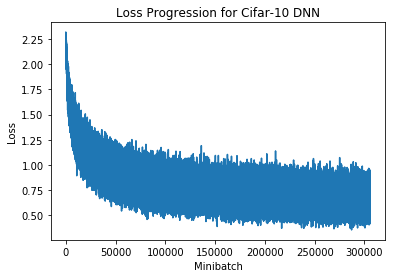

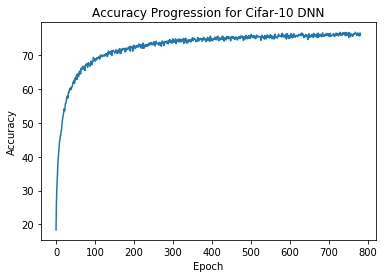

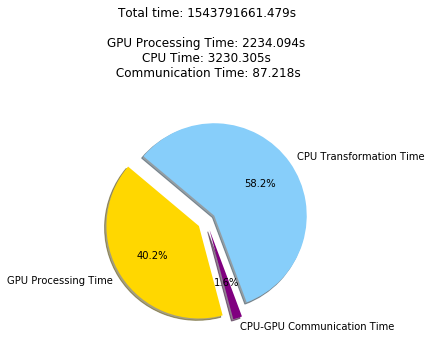

In [78]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import os
from IPython.display import display

# Let's gather all of those runs data
acc_progressions = []
all_losses       = []
runtimes         = []
pre_times        = []
pro_times        = []
com_times        = []
epochs           = []
accuracies       = []
networks         = []
network_sizes    = []
batch_sizes      = []
learning_rates   = []
iterations_batch = []
identities       = []
name             = "BasicCNN"
example          = 0
PATH             = "C:/Users/Jeff/Desktop/CSCE 689 Project/BasicCNN_Experiment/"
try:  
    os.mkdir(PATH)
except OSError:  
    print ("Directory already exists!")
else:  
    print ("Successfully created the directory.")

# Let's unpack the data
for trial in Run_Data:
    acc_progressions.append(trial.acc_progression)
    all_losses.append(trial.all_losses)
    runtimes.append(trial.runtime)
    pre_times.append(trial.pre_time)
    pro_times.append(trial.pro_time)
    com_times.append(trial.com_time)
    epochs.append(trial.rounds)
    accuracies.append(trial.accuracy)
    learning_rates.append(.003)
    identities.append(name + str(example))
    destination = PATH + identities[-1]
    try:
        os.mkdir(destination)
    except OSError:  
        print ("Directory already exists!")
    else:  
        print ("Successfully created the directory.")
    file_save = destination + "\\" + identities[-1]
    torch.save(trial.network, file_save)
    
    # Save the loss progression
    plt.figure()
    plt.title("Loss Progression for Cifar-10 DNN")
    plt.xlabel("Minibatch")
    plt.ylabel("Loss")
    plt.plot(all_losses[-1])
    fig_dest = destination + '\Loss_Progression.png'
    plt.savefig(fig_dest)
    
    plt.figure()
    plt.title("Accuracy Progression for Cifar-10 DNN")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(acc_progressions[-1])
    plt.savefig(destination + '\Accuracy_Progression.png')
    
    # Save the time spent computing
    plt.figure()
    labels = 'GPU Processing Time', 'CPU-GPU Communication Time', 'CPU Transformation Time'
    sizes = [pro_times[-1], pre_times[-1], com_times[-1]]
    colors = ['gold', 'purple','lightskyblue']
    explode = (0.1, 0.1, 0.1)  # explode 1st slice
 
    # Plot
    plt.title("Total time: %3.3fs\n\nGPU Processing Time: %3.3fs\nCPU Time: %3.3fs\n Communication Time: %3.3fs\n\n"% 
              (runtimes[-1], pro_times[-1], com_times[-1], pre_times[-1]))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=140)
 
    plt.axis('equal')
    plt.savefig(destination + '\Computation_Time_Chart.png')
    plt.show()
    
    net = 
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(targets, predicted)

    #cnf_matrix = confusion_matrix(targets, outputs)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Cifar-10 DNN Confusion Matrix')

    # Show the plot
    plt.savefig('Confusion_Matrix.pdf')
    plt.show()
    
    example += 1
    
# Let's recreate the runtime setup
for net_size in Network_Sizes:
    for batch_size in Batch_Sizes:
        for batch_loop in Batch_Loops:
            network_sizes.append(net_size)
            batch_sizes.append(batch_size)
            iterations_batch.append(batch_loop)

# Finally, place it into a dataframe
Cifar10_Dataset = pd.DataFrame({
                         'Runtime'              : runtimes,
                         'CPU Time'             : com_times,
                         'Communication Time'   : pre_times,
                         'GPU Time'             : pro_times,
                         'Epochs'               : epochs,
                         'Final Accuracy'       : accuracies,
                         'Network Size'         : network_sizes,
                         'Batch Size'           : batch_sizes,
                         'Learning Rate'        : learning_rates,
                         'Minibatch Recycle'    : iterations_batch,
                         'Identity'             : identities},
                       columns=['Final Accuracy','Network Size','Batch Size','Learning Rate',
                                'Minibatch Recycle','Runtime','GPU Time','CPU Time',
                                'Communication Time','Epochs', 'Identity'])
Cifar10_Dataset.sort_values("Final Accuracy")
Cifar10_Dataset.to_csv(PATH + "\Run_Data.csv", sep=',')

Now, let's save the network weights as well as visuals:
---
- Network dictionary
- Accuracy/Loss Visualization
- Runtime "Time Spent" Visualization

First off, now that the DNN is trained, let's save learned weights for later.
---
- Source: https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Source: https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch

In [44]:
# Save the state dictionary
PATH = "C:/Users/Jeff/Desktop/CSCE 689 Project/BasicCNN_Experiment/"
torch.save(net.state_dict(), PATH)

# Test to see if the save was successful before overwriting
testnet = Net(128)
testnet.load_state_dict(torch.load(PATH))

temp = net
net  = testnet
test(0)

[Time: 1.645s][epoch   0] Loss: 0.673 | Acc: 76.250% (7625/10000)


76.25

Let's take a look at the loss progression:
---

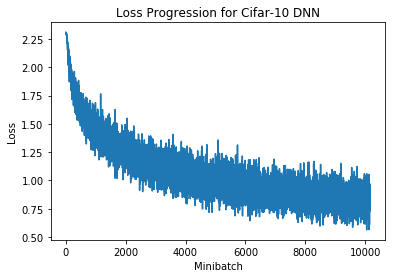

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.title("Loss Progression for Cifar-10 DNN")
plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.plot(all_losses)
plt.savefig('Loss_Progression.png')

Next, as a measure of effectiveness, let's see the accuracy progression:
---
Note that, to save computation time, accuracy was tested once per epoch rather than once per minibatch, and thus lacks the resolution of the loss progression.

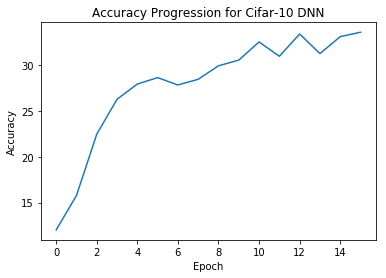

In [57]:
plt.figure()
plt.title("Accuracy Progression for Cifar-10 DNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(acc_progression)
plt.savefig('Accuracy_Progression.png')

Here's the Confusion Matrix:
---
Source for formatting, tailored to Cifar10: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

Traceback (most recent call last):
Traceback (most recent call last):
  File "E:\Anaconda2\envs\fastai\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "E:\Anaconda2\envs\fastai\lib\multiprocessing\queues.py", line 230, in _feed
    close()
  File "E:\Anaconda2\envs\fastai\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "E:\Anaconda2\envs\fastai\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
  File "E:\Anaconda2\envs\fastai\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "E:\Anaconda2\envs\fastai\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
OSError: [WinError 6] The handle is invalid


[Time: 1.572s] Loss: 2.669 | Acc: 36.230% (3623/10000)


E:\Anaconda2\envs\fastai\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
E:\Anaconda2\envs\fastai\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


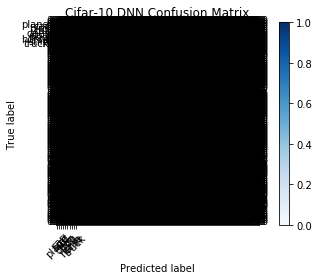

In [58]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Test the dataset
start = time.time()
global best_acc
net.eval()
test_loss = 0
correct = 0
total = 0
    
losses = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        losses.append(loss.item())
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    stop = time.time()
    print('[Time: %4.3fs] Loss: %.3f | Acc: %.3f%% (%d/%d)'%(stop - start, test_loss/(batch_idx+1), 100.*correct/total, correct, total))

# Compute confusion matrix
cnf_matrix = confusion_matrix(targets, predicted)

#cnf_matrix = confusion_matrix(targets, outputs)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Cifar-10 DNN Confusion Matrix')

# Show the plot
plt.savefig('Confusion_Matrix.pdf')
plt.show()

Lastly, let's take a look at how much time was spent during each section of computation.
---
Source: https://pythonspot.com/matplotlib-pie-chart/

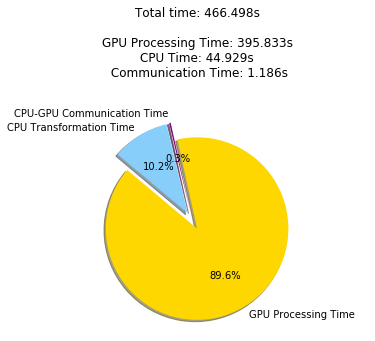

In [59]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'GPU Processing Time', 'CPU-GPU Communication Time', 'CPU Transformation Time'
sizes = [pro_time, pre_time, com_time]
colors = ['gold', 'purple','lightskyblue']
explode = (0.1, 0.1, 0.1)  # explode 1st slice
 
# Plot
plt.title("Total time: %3.3fs\n\nGPU Processing Time: %3.3fs\nCPU Time: %3.3fs\n Communication Time: %3.3fs\n\n"% (epoch_times[-1][-1], pro_time, com_time, pre_time))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()
plt.savefig('Computation_Time_Chart.pdf')